# THETA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**
adapted from `poster-figs.ipynb`

In [3]:
from dask.distributed import Client

client = Client("tcp://10.32.16.235:39667")
client

Client Scheduler: tcp://10.32.16.235:39667 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [5]:
xr.set_options(display_style='text')

In [6]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_tmp, ds_vel])
ds

<xarray.Dataset>
Dimensions:                  (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                 (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
  * k_l                      (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    SALT                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp                (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt                       (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 50), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                     (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                     (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

### Checking if `rhs` and `lhs` seem to match

In [7]:
rhs_vars = [dvar for dvar in ds_tmp.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_tmp[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

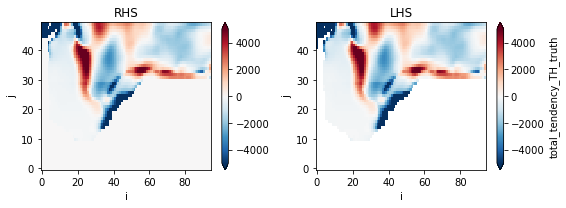

In [10]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=5e3)
ax0.set_title('RHS')

ds.total_tendency_TH_truth[1, 0].plot(ax=ax1, robust=True, vmax=5e3)
ax1.set_title('LHS')
plt.tight_layout();

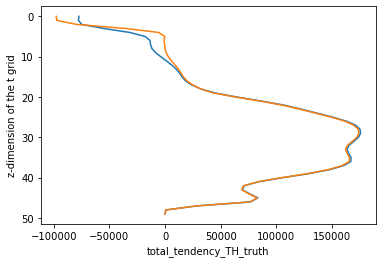

In [11]:
delta_theta = ds.THETA_snp.isel(time_snp=-1) - ds.THETA_snp.isel(time_snp=0)
total_time = (ds.time_snp[-1] - ds.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_theta * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
ds.total_tendency_TH_truth.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>

In [14]:
# define bins
delta_theta = 0.1
theta_bins = np.arange(-2, 4, delta_theta)
#define theta_bines for WG range

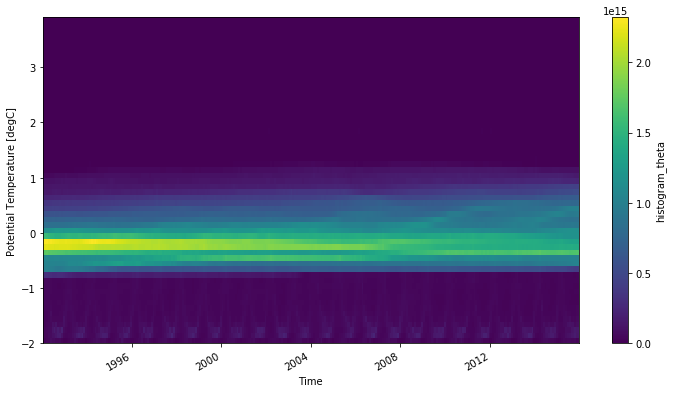

In [15]:
# theta distribution in WG region
theta_dist = histogram(ds.THETA_snp.rename('theta'), bins=[theta_bins],
                       weights=vol, dim=['i', 'j', 'k'])
theta_dist.plot(x='time_snp', figsize=(12, 6))

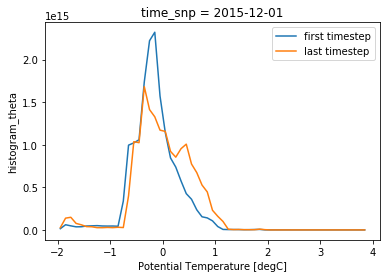

In [16]:
theta_dist[0].plot(label='first timestep')
theta_dist[-1].plot(label='last timestep')
plt.legend();

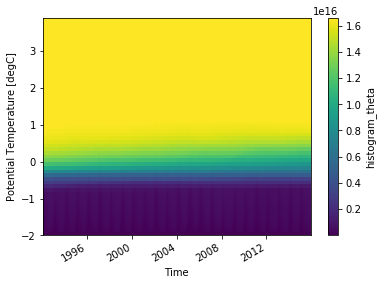

In [17]:
# cumulative volume
V = theta_dist.cumsum(dim='theta_bin')
V.transpose().plot()

In [18]:
V

<xarray.DataArray 'histogram_theta' (time_snp: 287, theta_bin: 59)>
dask.array<nancumsum, shape=(287, 59), dtype=float64, chunksize=(1, 59), chunktype=numpy.ndarray>
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

In [19]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds.time[1:-1].values

In [20]:
delta_V

<xarray.DataArray 'histogram_theta' (time_snp: 286, theta_bin: 59)>
dask.array<sub, shape=(286, 59), dtype=float64, chunksize=(1, 59), chunktype=numpy.ndarray>
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85
    time       (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [21]:
ds.dt[1:-1]

<xarray.DataArray 'dt' (time: 286)>
dask.array<getitem, shape=(286,), dtype=float32, chunksize=(286,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [29]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds.dt[1:-1]
dVdt.load()

<xarray.DataArray (time: 286, theta_bin: 59)>
array([[  2641806.14743295,  -3777985.21358876,  -7118363.39984674, ...,
                0.        ,         0.        ,         0.        ],
       [  5718294.78442055,   4319388.38040621,   6869735.18107527, ...,
                0.        ,         0.        ,         0.        ],
       [  4885779.96859259,  14025875.82380247,  18344917.81432099, ...,
                0.        ,         0.        ,         0.        ],
       ...,
       [ -3397265.30034568,   1272283.38844444,   5188570.66054321, ...,
                0.        ,         0.        ,         0.        ],
       [  4408831.15756272,  12989736.40009558,  23426245.39928316, ...,
                0.        ,         0.        ,         0.        ],
       [ -8380410.57916049, -22680698.02508642, -27939560.65916049, ...,
                0.        ,         0.        ,         0.        ]])
Coordinates:
    time_snp   (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85
  * time       (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

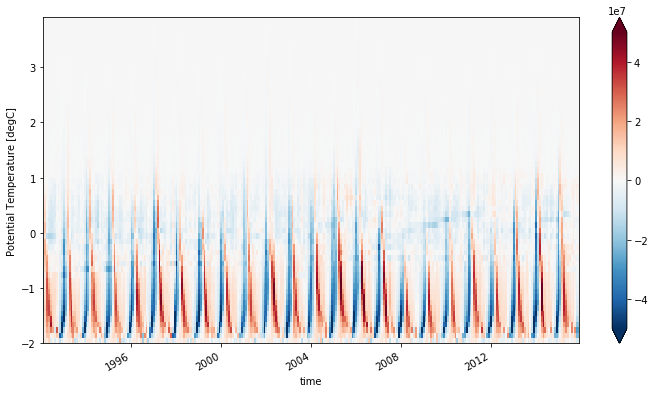

In [22]:
dVdt.plot(x='time', figsize=(12, 6), vmax=5e7)

## $\Omega_{total}$

In [26]:
omega_total = -histogram(ds.THETA.rename('theta').chunk({'i':-1}), bins=[theta_bins],
                         weights=ds.total_tendency_TH_truth.fillna(0.),
                         dim=['i', 'j', 'k']) / delta_theta

In [31]:
omega_total.load()

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 59)>
array([[       -0.        ,        -0.        ,        -0.        , ...,
               -0.        ,        -0.        ,        -0.        ],
       [  2498695.7646066 ,  -1252584.30323146,  -5185913.32274809, ...,
               -0.        ,        -0.        ,        -0.        ],
       [  1356810.83122147,   3606710.03942311,   3388779.21865344, ...,
               -0.        ,        -0.        ,        -0.        ],
       ...,
       [   900872.86891088,  11938447.23325906,  27211905.78876394, ...,
               -0.        ,        -0.        ,        -0.        ],
       [ -2417410.18779832, -17067731.64495367, -36310164.93532807, ...,
               -0.        ,        -0.        ,        -0.        ],
       [       -0.        ,        -0.        ,        -0.        , ...,
               -0.        ,        -0.        ,        -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

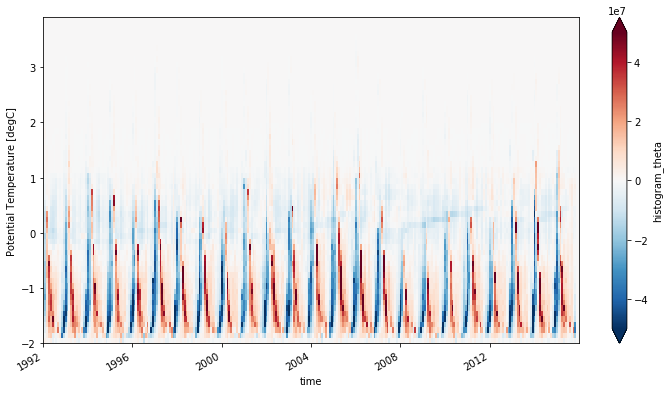

In [27]:
omega_total.plot(x='time', figsize=(12, 6), vmax=5e7)

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

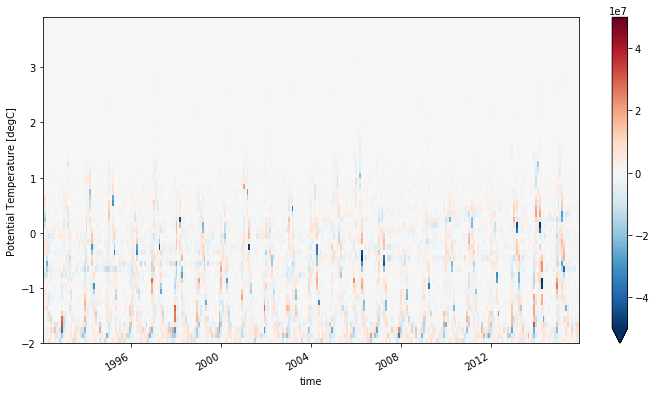

In [35]:
R1 = dVdt - omega_total[1:-1]
R1.plot(x='time', figsize=(12, 6), vmax=5e7)

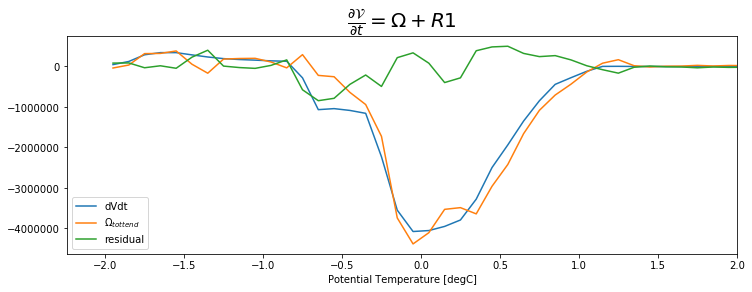

In [40]:
plt.figure(figsize=(12,4))
dVdt.mean(dim='time').plot(label='dVdt')
omega_total.mean(dim='time').plot(label=r'$\Omega_{tottend}$')
R1.mean(dim='time').plot(label='residual')
plt.legend()
plt.xlim(xmax=2)
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20);

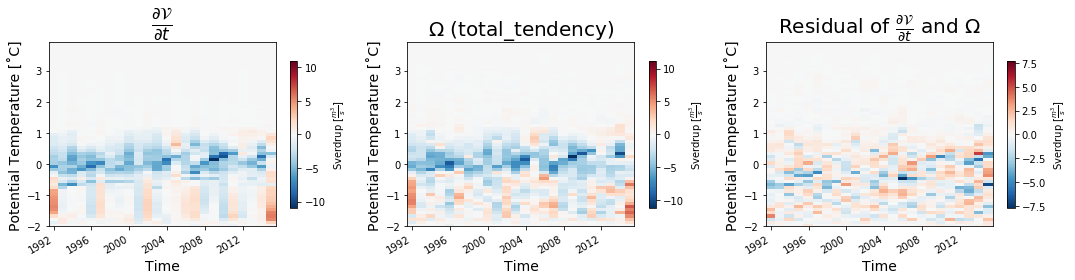

In [41]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)

plt.tight_layout();

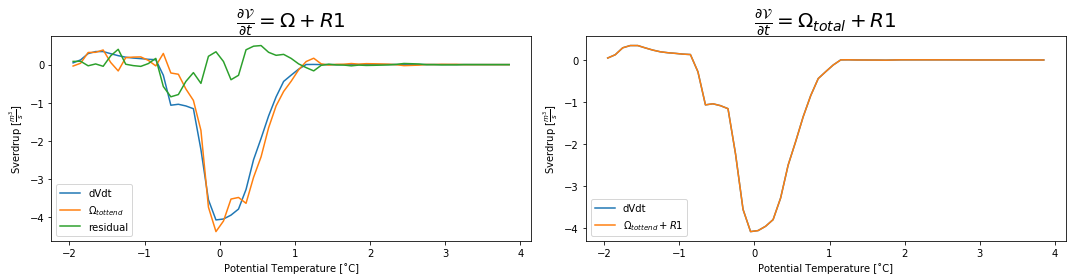

In [45]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [54]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds.THETA.rename('theta').chunk({'i':-1}), bins=[theta_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / delta_theta

In [55]:
all_tendencies = list(ds_tmp)
all_tendencies

['conv_horiz_adv_flux_TH',
 'conv_horiz_diff_flux_TH',
 'conv_vert_adv_flux_TH',
 'conv_vert_diff_flux_TH',
 'surface_flux_conv_TH',
 'sw_flux_conv_TH',
 'total_tendency_TH_truth']

In [56]:
all_dsets = xr.merge([histogram_func(ds_tmp[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])
all_dsets

<xarray.Dataset>
Dimensions:                        (theta_bin: 59, time: 288)
Coordinates:
  * time                           (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * theta_bin                      (theta_bin) float64 -1.95 -1.85 ... 3.75 3.85
Data variables:
    OMEGA_conv_horiz_adv_flux_TH   (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_TH  (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_TH    (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_TH   (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_surface_flux_conv_TH     (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_sw_flux_conv_TH          (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_total_tendency_TH_truth  (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>

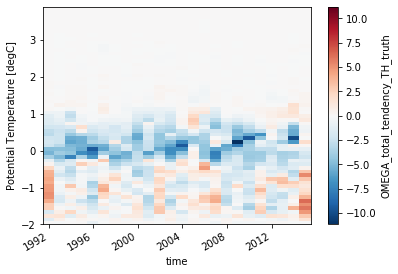

In [60]:
#checking to see if it looks the same as omega_total subplot above (and it does!)
(-all_dsets.OMEGA_total_tendency_TH_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time')

In [62]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_TH + 
                      all_dsets.OMEGA_conv_vert_diff_flux_TH +
                      all_dsets.OMEGA_sw_flux_conv_TH + 
                      all_dsets.OMEGA_surface_flux_conv_TH)
omega_trans_rate.load()

<xarray.DataArray (time: 288, theta_bin: 59)>
array([[  -510212.9802525 ,  -6976130.7512936 , -15229294.35483515, ...,
               -0.        ,        -0.        ,        -0.        ],
       [  2409945.66590786,   -648354.33263525,  -4177476.78051434, ...,
               -0.        ,        -0.        ,        -0.        ],
       [   163631.0441488 ,   3572633.16201303,   4484636.89591644, ...,
               -0.        ,        -0.        ,        -0.        ],
       ...,
       [   806098.15007944,  11347848.99701025,  27303413.47410893, ...,
               -0.        ,        -0.        ,        -0.        ],
       [ -2526622.7114782 , -15705979.6051656 , -32921584.12541023, ...,
               -0.        ,        -0.        ,        -0.        ],
       [  -830548.71791439, -13668761.53492914, -33463705.31514266, ...,
               -0.        ,        -0.        ,        -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

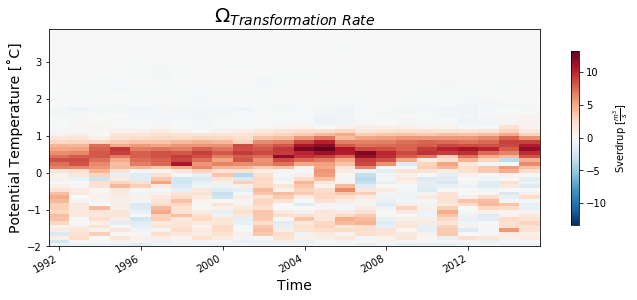

In [64]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(11,4), 
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Omega_{Transformation\ Rate}$', fontsize=20);

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [65]:
psi_adv = -(all_dsets.OMEGA_conv_horiz_adv_flux_TH + all_dsets.OMEGA_conv_vert_adv_flux_TH)

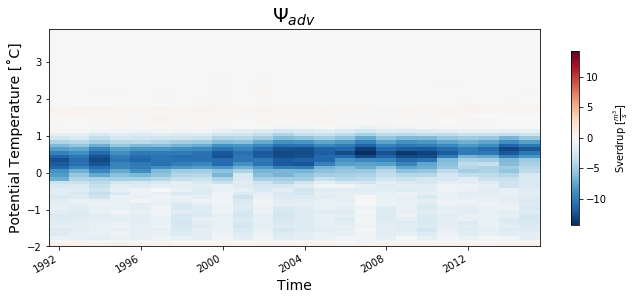

In [66]:
(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Psi_{adv}$', fontsize=20);

## $\Psi_{vel}$

In [74]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=0)
v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(k_l=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [83]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

In [85]:
v_transport_mean_value = v_transport.mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [87]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [88]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [92]:
# hack theta to be on same grid pt as velocity components
theta_at_u_right = ds.THETA.isel(i=-1)
theta_at_u_left = ds.THETA.isel(i=0)
theta_at_v = ds.THETA.isel(j=-1)
theta_at_w = ds.THETA.isel(k=0)

In [101]:
#this is the delta function part of the equation above
u_binned_right = histogram(theta_at_u_right.rename('theta'), bins=[theta_bins],
                     weights=u_transport_right, dim=['k', 'j'])
u_binned_left = histogram(theta_at_u_left.rename('theta'), bins=[theta_bins],
                     weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(theta_at_v.rename('theta'), bins=[theta_bins],
                     weights=v_transport, dim=['k', 'i'])
w_binned = histogram(theta_at_w.rename('theta'), bins=[theta_bins],
                     weights=w_transport, dim=['i', 'j'])

In [103]:
psi_vel = -(u_binned_right + u_binned_left + v_binned).cumsum(dim='theta_bin')

In [106]:
psi_vel.load()

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 59)>
array([[       -0.        ,        -0.        ,     85116.85449219, ...,
        -30604726.66082716, -30604726.66082716, -30604726.66082716],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -27805344.78760284, -27805344.78760284, -27805344.78760284],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -32200995.03842318, -32200995.03842318, -32200995.03842318],
       ...,
       [       -0.        ,  -1156920.9921875 ,  -2394502.57438278, ...,
        -33500931.14900935, -33500931.14900935, -33500931.14900935],
       [       -0.        ,    182620.70584869,  -2919371.47412777, ...,
        -29893546.89956188, -29893546.89956188, -29893546.89956188],
       [       -0.        ,        -0.        ,    -80818.07821655, ...,
        -28088308.78935134, -28088308.78935134, -28088308.78935134]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

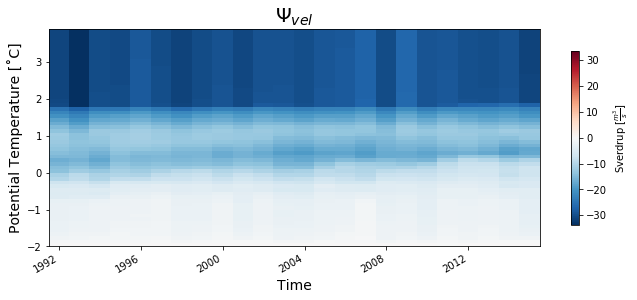

In [105]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20);

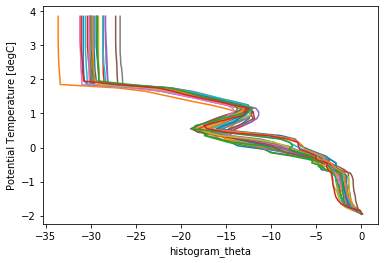

In [107]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='theta_bin', add_legend=False);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

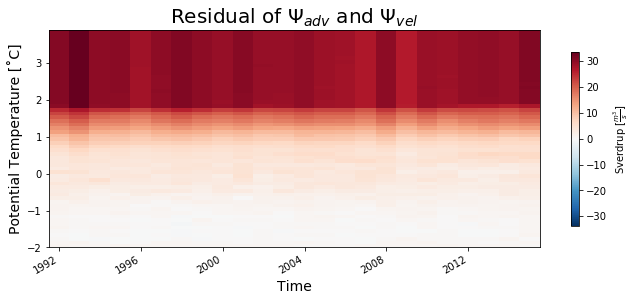

In [108]:
R2 = psi_adv - psi_vel
(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'Residual of $\Psi_{adv}$ and $\Psi_{vel}$', fontsize=20);

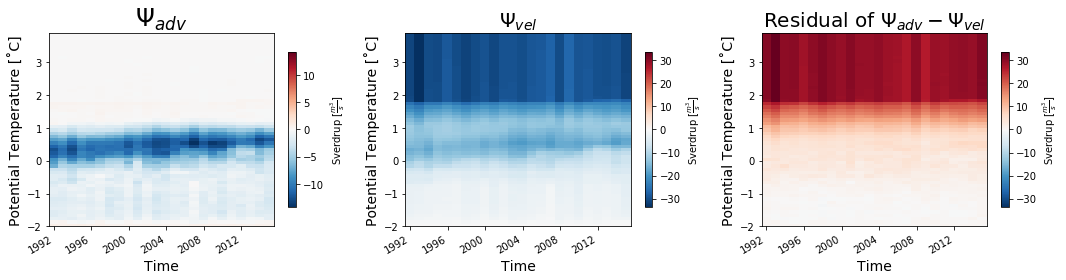

In [114]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\Psi_{adv}$', fontsize=24)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Psi_{vel}$', fontsize=20)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$', fontsize=20)

plt.tight_layout();

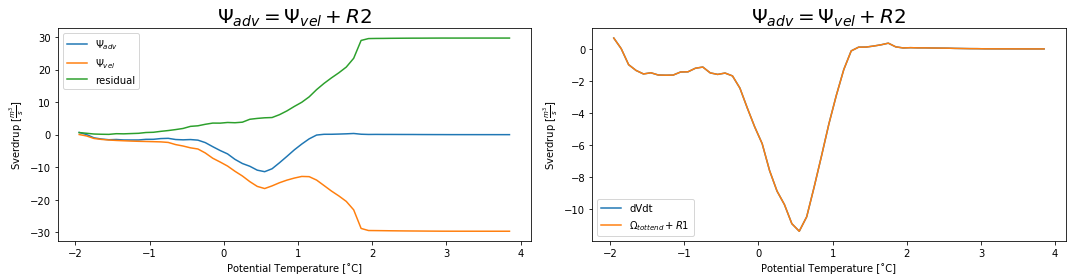

In [115]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

(psi_adv/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [161]:
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 288, theta_bin: 59)>
array([[7.08886418e+05, 7.97603840e+06, 1.65585252e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.22616422e+04, 1.56930696e+04, 2.00333614e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.57028349e+04, 5.04059895e+04, 8.98226709e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.49737418e+04, 3.76082604e+05, 6.59130728e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.65933709e+03, 5.35088429e+04, 7.94595105e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.01072585e+06, 1.53033527e+07, 3.51791544e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

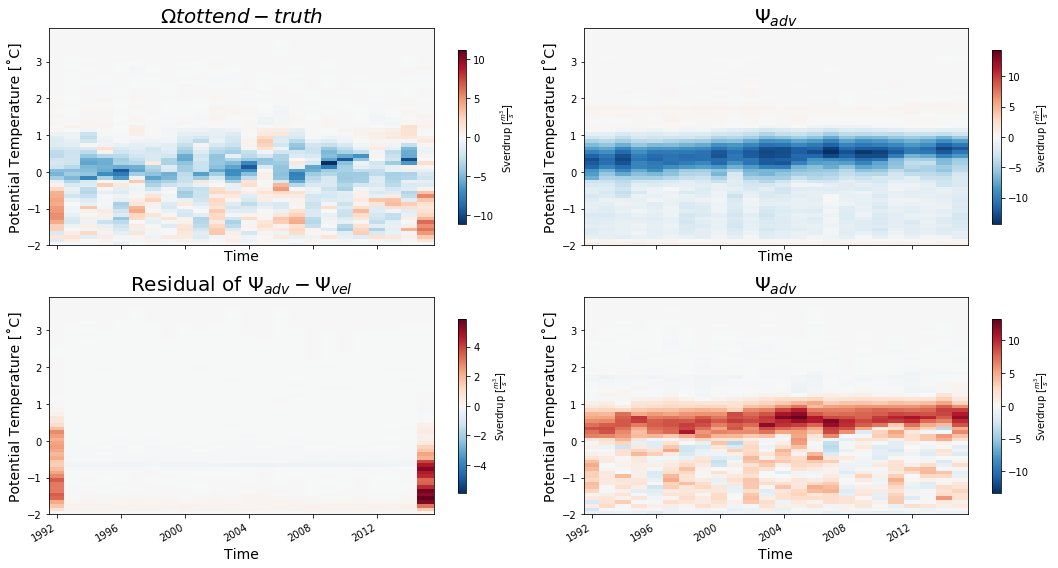

In [165]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0],
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$', fontsize=20)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Psi_{adv}$', fontsize=20)

plt.tight_layout();

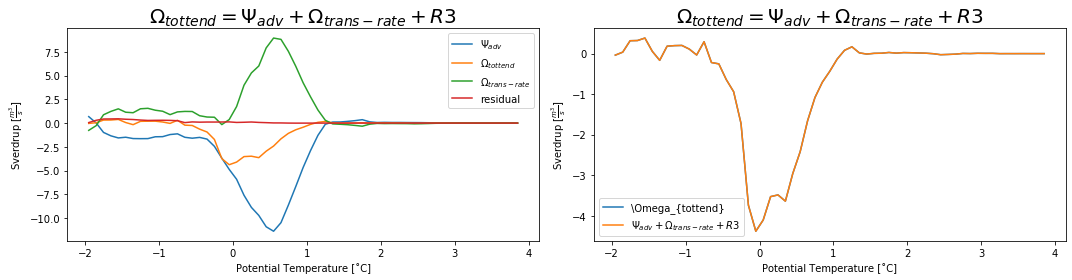

In [167]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)

(omega_total/1e6).mean(dim='time').plot(label='\Omega_{tottend}', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)

plt.tight_layout();

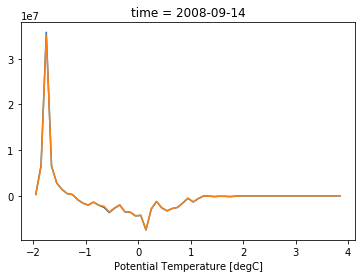

In [158]:
n = 200
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()


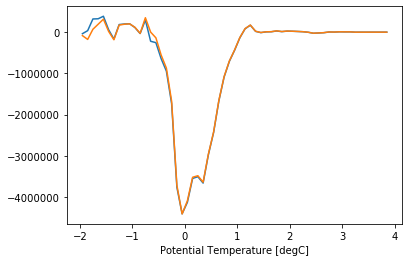

In [159]:
omega_total.isel(time=slice(1, -1)).mean(dim='time').plot()
(omega_trans_rate + psi_adv).isel(time=slice(1, -1)).mean(dim='time').plot()

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{adv} + \Omega_{trans-rate} + R1 \end{equation*} </font>

(2.2, -2.2)

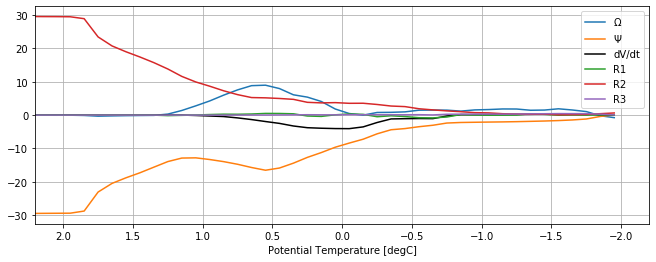

In [171]:
(omega_trans_rate[1:-1]/1e6).mean(dim='time').plot(figsize=(11,4), label=r'$\Omega$')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R2/1e6).mean(dim='time').plot(label='R2')
(R3/1e6).mean(dim='time').plot(label='R3')
plt.legend()
plt.grid()
plt.xlim(2.2, -2.2)

### **Explanation:**
- If you have positive transformation in $\sigma$ bins, the water is getting lighter. So if you have positive transformation in $\theta$ bins, that means the water is getting warmer, no? And similarly, negative transformation in $\sigma$ bins means water is getting denser, so negative transformation in $\theta$ bins means water is getting colder.

(2, -2.5)

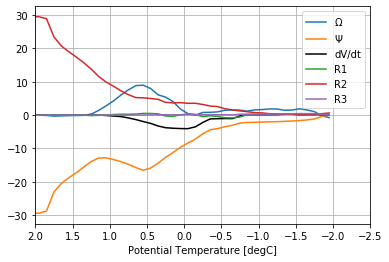

In [172]:
(omega_trans_rate[1:-1]/1e6).mean(dim='time').plot(label=r'$\Omega$')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R2/1e6).mean(dim='time').plot(label='R2')
(R3/1e6).mean(dim='time').plot(label='R3')
plt.legend()
plt.grid()
plt.xlim(2, -2.5)

In [146]:
omega_mix = -(all_dsets.OMEGA_conv_horiz_diff_flux_TH + 
                      all_dsets.OMEGA_conv_vert_diff_flux_TH)
omega_surf = - (all_dsets.OMEGA_sw_flux_conv_TH + 
                      all_dsets.OMEGA_surface_flux_conv_TH)

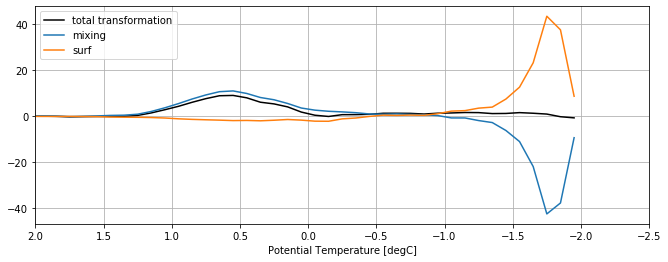

In [147]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(11,4), label='total transformation', color='k')
(omega_mix/1e6).mean(dim='time').plot(label='mixing')
(omega_surf/1e6).mean(dim='time').plot(label='surf')
plt.legend()
plt.grid()
plt.xlim(2, -2.5);

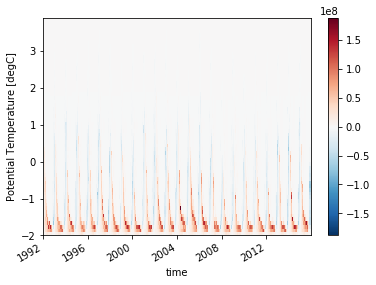

In [149]:
omega_surf.plot(x='time')

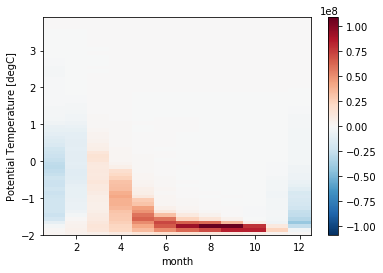

In [150]:
omega_surf.groupby('time.month').mean(dim='time').plot(x='month')

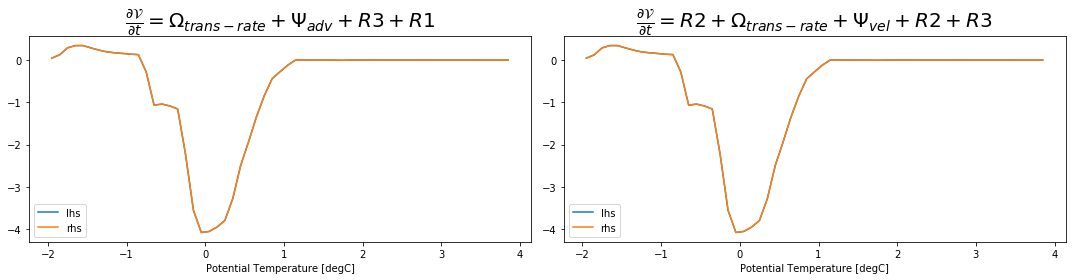

In [174]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate[1:-1] + psi_adv[1:-1] + R3[1:-1] + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R3 + R1$', fontsize=20, fontweight='bold')
ax0.legend()

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2 + R3)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = R2 + \Omega_{trans-rate} + \Psi_{vel} + R2 + R3$', fontsize=20, fontweight='bold')
ax1.legend()

plt.tight_layout();

## <span style='background:Yellow'> Checking to see if orig ds vel vars work </span>
bc Psi_vel looks funny with the warm bins having the largest export

In [116]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [117]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [118]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
ds['theta'] = ds.THETA.rename('theta')

In [120]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [121]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [122]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [123]:
ds_weddell = ds.isel(**lon_range, **lat_range)
ds_weddell.nbytes/1e6

6365.498312

In [125]:
coords_wg = coords.isel(**lon_range, **lat_range)

## $\Psi_{vel}$ from original ds

In [126]:
#this is the "dA" part of the equation
u_transport_right = (ds_weddell.UVELMASS * coords_wg.dyG * coords_wg.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds_weddell.UVELMASS * coords_wg.dyG * coords_wg.drF).isel(i_g=0)
v_transport = (ds_weddell.VVELMASS * coords_wg.dxG * coords_wg.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds_weddell.WVELMASS.isel(k_l=0) * coords_wg.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [127]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

In [128]:
v_transport_mean_value = v_transport.mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [129]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [130]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [131]:
# hack theta to be on same grid pt as velocity components
theta_at_u_right = ds_weddell.theta.isel(i=-1)
theta_at_u_left = ds_weddell.theta.isel(i=0)
theta_at_v = ds_weddell.theta.isel(j=-1)
theta_at_w = ds_weddell.theta.isel(k=0)

In [132]:
#this is the delta function part of the equation above
u_binned_right = histogram(theta_at_u_right.rename('theta'), bins=[theta_bins],
                     weights=u_transport_right, dim=['k', 'j'])
u_binned_left = histogram(theta_at_u_left.rename('theta'), bins=[theta_bins],
                     weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(theta_at_v.rename('theta'), bins=[theta_bins],
                     weights=v_transport, dim=['k', 'i'])
w_binned = histogram(theta_at_w.rename('theta'), bins=[theta_bins],
                     weights=w_transport, dim=['i', 'j'])

In [133]:
psi_vel = -(u_binned_right + u_binned_left + v_binned).cumsum(dim='theta_bin')

In [134]:
psi_vel.load()

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 59)>
array([[       -0.        ,        -0.        ,     85116.85449219, ...,
        -30604726.66082716, -30604726.66082716, -30604726.66082716],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -27805344.78760284, -27805344.78760284, -27805344.78760284],
       [       -0.        ,        -0.        ,        -0.        , ...,
        -32200995.03842318, -32200995.03842318, -32200995.03842318],
       ...,
       [       -0.        ,  -1156920.9921875 ,  -2394502.57438278, ...,
        -33500931.14900935, -33500931.14900935, -33500931.14900935],
       [       -0.        ,    182620.70584869,  -2919371.47412777, ...,
        -29893546.89956188, -29893546.89956188, -29893546.89956188],
       [       -0.        ,        -0.        ,    -80818.07821655, ...,
        -28088308.78935134, -28088308.78935134, -28088308.78935134]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

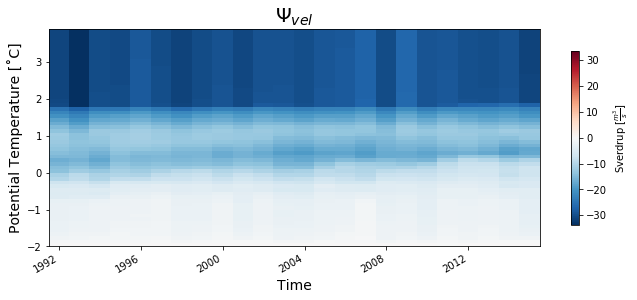

In [135]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(11,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20);